In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

# Load the train and test dataset
train_generator = train_datagen.flow_from_directory(
    'dataset/jajanan/train',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'dataset/jajanan/test',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 1884 images belonging to 8 classes.
Found 473 images belonging to 8 classes.


In [2]:
import tensorflow_hub as hub
ResNet_V2_50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
Inception_V3 = 'https://tfhub.dev/google/imagenet/inception_v3/classification/5'
MobileNet_V3_Large = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5'
Inception_ResNet_V2 = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5'
NASNet_Large = 'https://tfhub.dev/google/imagenet/nasnet_large/classification/5'


In [3]:
# use GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  except RuntimeError as e:
    print(e)

# model_ResNet = tf.keras.Sequential([
#     hub.KerasLayer(ResNet_V2_50, trainable = False, input_shape = (224,224,3), name = 'Resnet_V2_50'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(8, activation = 'softmax', name = 'Output_layer')
# ])

# model_Inception = tf.keras.Sequential([
#     hub.KerasLayer(Inception_V3, trainable = False, input_shape = (224,224,3), name = 'Inception_V3'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(8, activation = 'softmax', name = 'Output_layer')
# ])

# model_MobileNet = tf.keras.Sequential([
#     hub.KerasLayer(MobileNet_V3_Large, trainable = False, input_shape = (224,224,3), name = 'MobileNet_V3_Large'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(8, activation = 'softmax', name = 'Output_layer')
# ])

model_Inception_ResNet = tf.keras.Sequential([
    hub.KerasLayer(Inception_ResNet_V2, trainable = False, input_shape = (224,224,3), name = 'Inception_ResNet_V2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation = 'softmax', name = 'Output_layer')
])

# model_NASNet = tf.keras.Sequential([
#     hub.KerasLayer(NASNet_Large, trainable = False, input_shape = (331,331,3), name = 'NASNet_Large'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(8, activation = 'softmax', name = 'Output_layer')
# ])

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 30:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [5]:
model = model_Inception_ResNet

In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

model_history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_steps=test_generator.n // test_generator.batch_size,
    validation_data=test_generator,
    callbacks=[callbacks, lr_scheduler, early_stopping]
)

Epoch 1/50
58/58 [==============================] - 43s 434ms/step - loss: 2.5740 - accuracy: 0.6528 - val_loss: 1.6632 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - 21s 351ms/step - loss: 1.6297 - accuracy: 0.7954 - val_loss: 1.4400 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - 20s 334ms/step - loss: 1.4617 - accuracy: 0.8078 - val_loss: 1.4556 - val_accuracy: 0.8147 - lr: 0.0010
Epoch 4/50
58/58 [==============================] - 20s 349ms/step - loss: 1.2760 - accuracy: 0.8564 - val_loss: 1.2720 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 5/50
58/58 [==============================] - 20s 340ms/step - loss: 1.2187 - accuracy: 0.8558 - val_loss: 1.2264 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 6/50
58/58 [==============================] - 19s 333ms/step - loss: 1.1575 - accuracy: 0.8661 - val_loss: 1.1940 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 7/50
58/58 [==============================] - 19s 328ms/st

In [8]:
import datetime
model.save('model_InceptionResnet_{}.keras'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

1/1 [==============================] - 0s 78ms/step
Total wrong prediction:  59
Total test data:  473
Accuracy:  0.8752642706131079
Wrong prediction percentage:  [0.15942029 0.05194805 0.02631579 0.28301887 0.02631579 0.175
 0.16455696 0.        ]
Actual percentage:  [0.11594203 0.06493506 0.10526316 0.22641509 0.05263158 0.0375
 0.27848101 0.07692308]


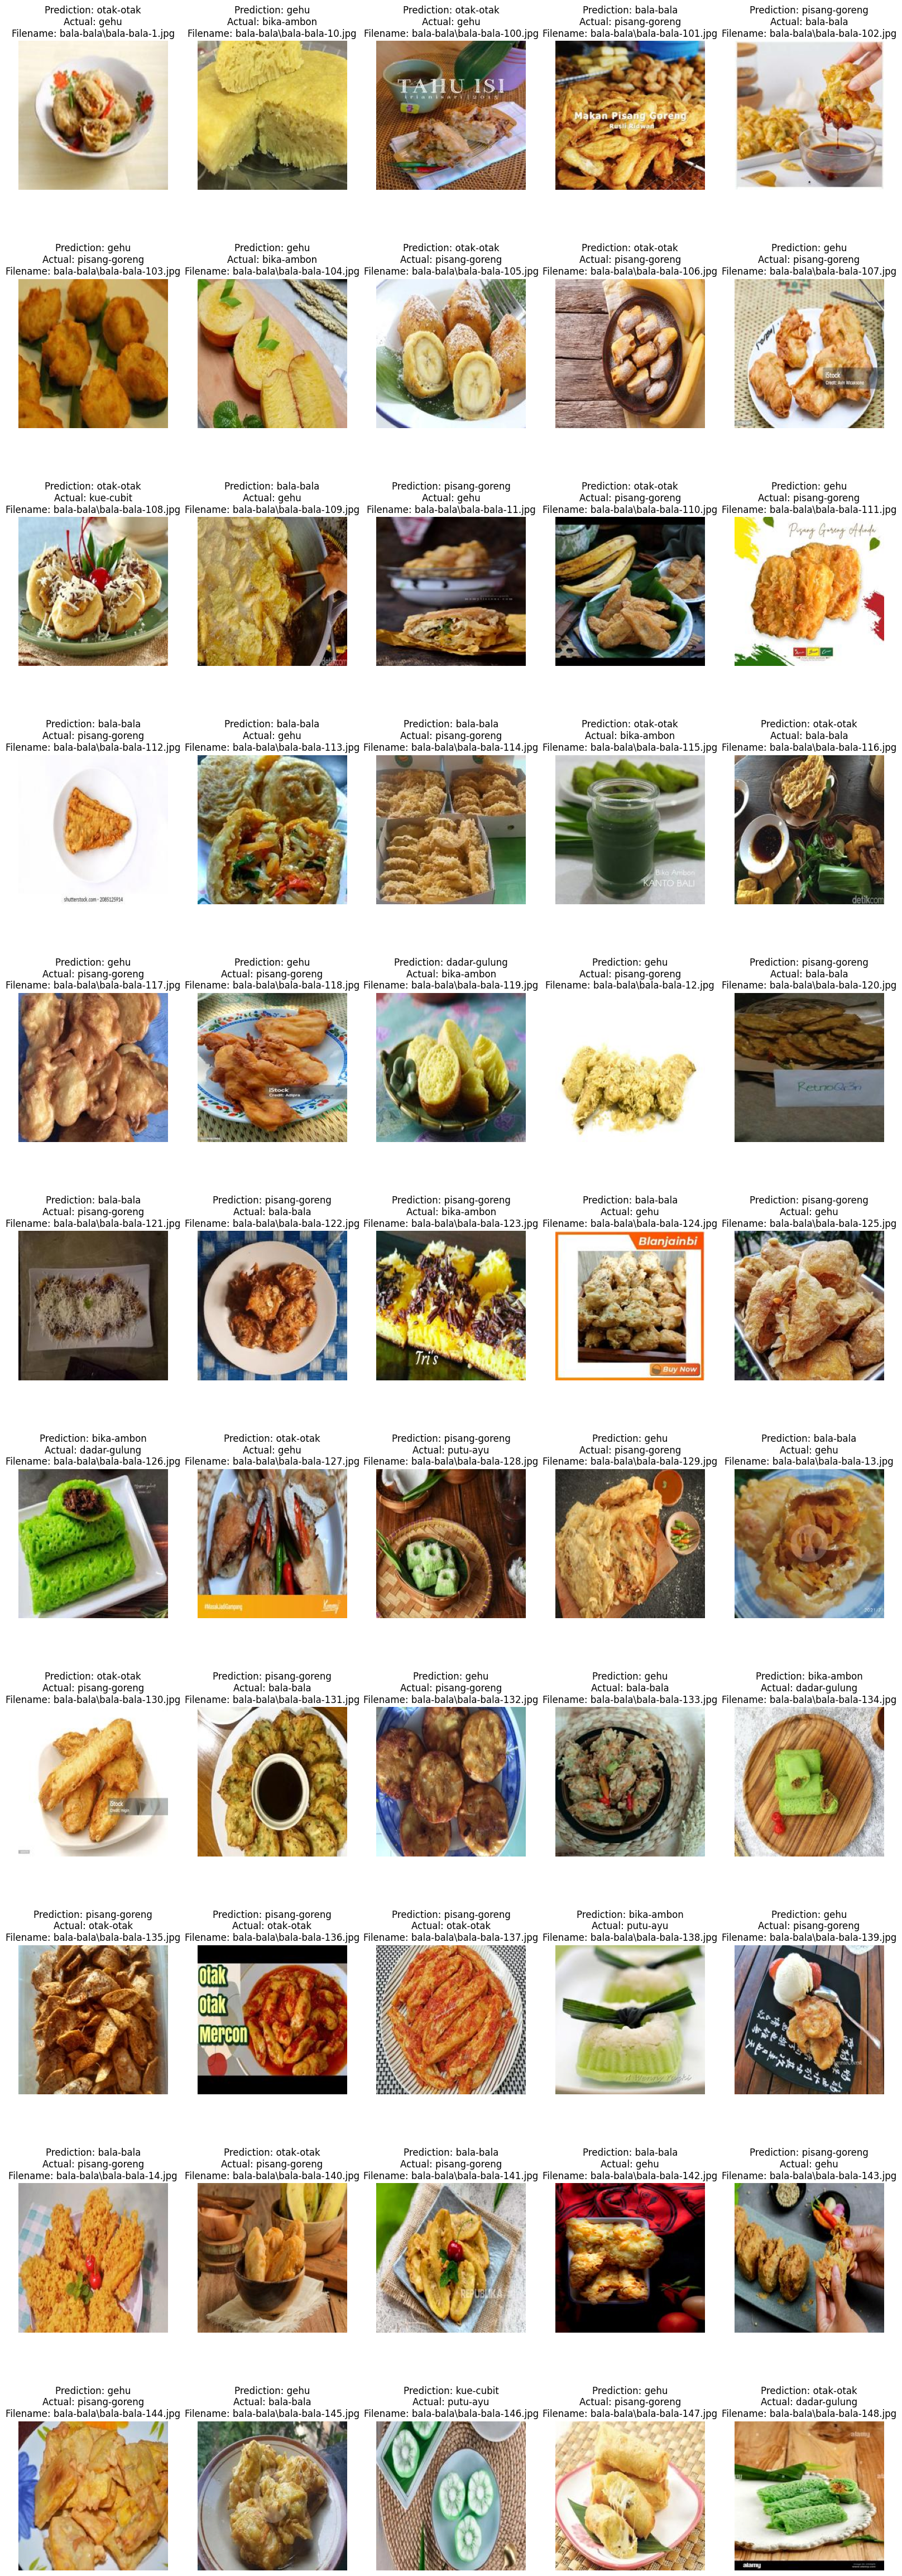

In [34]:
# predict the test dataset again and show the result, every image with wrong prediction will be shown and ignored if the prediction is correct
import numpy as np
import matplotlib.pyplot as plt

class_names = ['bala-bala', 'bika-ambon', 'dadar-gulung', 'gehu', 'kue-cubit', 'otak-otak', 'pisang-goreng', 'putu-ayu']

wrong_predictions = []
wrong_images = []
wrong_labels = []
wrong_pred_percentage = np.zeros(8)
wrong_actual_percentage = np.zeros(8)
total_class_data = np.zeros(8)
total_test_data = 0
# predict all batch test data
# randomize the test data
test_generator.reset()
for k in range(np.ceil(test_generator.n / test_generator.batch_size).astype(int)):
  test_images, test_labels = next(test_generator)
  predictions = model.predict(test_images)
  for i in range(len(predictions)):
    if class_names[np.argmax(predictions[i])] != class_names[np.argmax(test_labels[i])]:
      wrong_predictions.append(predictions[i])
      wrong_images.append(test_images[i])
      wrong_labels.append(test_labels[i])
      wrong_pred_percentage[np.argmax(predictions[i])] += 1
      wrong_actual_percentage[np.argmax(test_labels[i])] += 1
    total_class_data[np.argmax(test_labels[i])] += 1
    total_test_data += 1

print('Total wrong prediction: ', len(wrong_predictions))
print('Total test data: ', total_test_data)
print('Accuracy: ', (total_test_data - len(wrong_predictions)) / total_test_data)
print('Wrong prediction percentage: ', wrong_pred_percentage / total_class_data)
print('Wrong Actual percentage: ', wrong_actual_percentage / total_class_data)

# count the wrong prediction for each class
wrong_prediction_count = np.zeros(8)

fig = plt.figure(figsize=(20, 60))
for i in range(len(wrong_predictions) // 5):
  for j in range(5):
    ax = fig.add_subplot(len(wrong_predictions) // 5, 5, i * 5 + j + 1)
    ax.imshow(wrong_images[i * 5 + j])
    ax.set_title('Prediction: ' + class_names[np.argmax(wrong_predictions[i * 5 + j])] + '\nActual: ' + class_names[np.argmax(wrong_labels[i * 5 + j])] + '\nFilename: ' + test_generator.filenames[i * 5 + j])
    ax.axis('off')
